## Absolute astrometric calibration

We now have a combined, science-ready image... sort of.  In reality, doing any sort of scientific analysis on this image as it stands will be a big pain, because it doesn't contain any positional information.  If we wanted to extract information about a particular star or galaxy, or (worse) a whole list of objects, this would be extremely frustrating: we would have to scan the image by eye to find each object, write down its pixel coordinates, and send them one-by-one to our photometry or other analysis code.

Fortunately, the FITS format can encode astrometric (positional) information via the header, enabling us to transform (x,y) to (RA,Dec) and back again for any location in the image.  Basic header keywords encode the position, pixel scale, and rotation of the image (plus the spherical projection to be used); these are fully standardized and supported by nearly all astronomical software.  Additional keywords provide distortion terms to allow for deviations from perfectly rectilinear CCD/optics, although unfortunately there are several conflicting conventions for treating distortions and there is no guarantee that your software will support them correctly.

Solving astrometry requires matching a group of stars detected in your image to the stars in the catalog, and solving (fitting) for the parameters in the system of astrometric equations that relate pixel coordinates (x,y) to world coordinates (RA,Dec).  Doing this by hand is painstaking so we will use tools available that will do the astronomy or us. What we need is just a transformation matrix for going from one coordinate system to the other.

In [8]:
pip install astrometry-net-client

Note: you may need to restart the kernel to use updated packages.


Download the **astrometry net client** module in a different virtual environment to avoid dependency clashes. Ony the following cell requires this module.

`$ pip install astrometry-net-client`

Login to *nova.astrometry.net* and get your API key from profile section.

In [4]:
from astrometry_net_client import Session, FileUpload

def radec(file):
    # Define file paths
    file_path = os.path.join('/home/mayank/astronomybro/processing', file + '.fits')
    corr_file_path = os.path.join('/home/mayank/astronomybro/processing', file + '_corr.fits')

    # Check if files already exist
    if os.path.exists(corr_file_path) and os.path.exists(file_path):
        print(f"The file '{file}' has already been processed.")
        return

    try:
        # Create a session with the given API key
        session = Session(api_key='acpzsepjyiiyhyqp')
        # Upload the file
        upload = FileUpload(file_path, session=session)
        submission = upload.submit()
        submission.until_done()
        job = submission.jobs[0]
        job.until_done()

        # If the job is successful, write the output files
        if job.success():
            wcs = job.wcs_file()
            corr_table = job.corr_file()  # Positions in pixel coordinates of the stars detected
            astrom_file = job.new_fits_file()  # Original file with header containing the transformation matrix

            corr_table.writeto(corr_file_path, overwrite=True)
            astrom_file.writeto(file_path, overwrite=True)

            print("Astrometry job completed successfully.")
            print(job.info())
        else:
            print("Astrometry job failed.")
            print(job.info())
    
    except Exception as e:
        print(f"An error occurred: {e}")

In [7]:
radec('acam761.proc')
radec('acam762.proc')
radec('acam763.proc')

The file 'acam761.proc' has already been processed.
The file 'acam762.proc' has already been processed.
The file 'acam763.proc' has already been processed.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
import warnings
import os
import subprocess

#warnings.filterwarnings("ignore")

We're using an Astropy Table, read about it from here https://docs.astropy.org/en/stable/api/astropy.table.Table.html. Using it's data is similar to **pandas**.

In [24]:
corr2 = fits.open('/home/mayank/astronomybro/processing/acam761.proc_corr.fits')

data = corr2[1].data
table = Table(data)

print(table.colnames)

['field_x', 'field_y', 'field_ra', 'field_dec', 'index_x', 'index_y', 'index_ra', 'index_dec', 'index_id', 'field_id', 'match_weight', 'FLUX', 'BACKGROUND']


Now we'll plot the reference stars the software used to obtain the trasformation to see if it did that correctly

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '2018-07-14        ' to '2018-07-14T00:00:00.0''. [astropy.wcs.wcs]


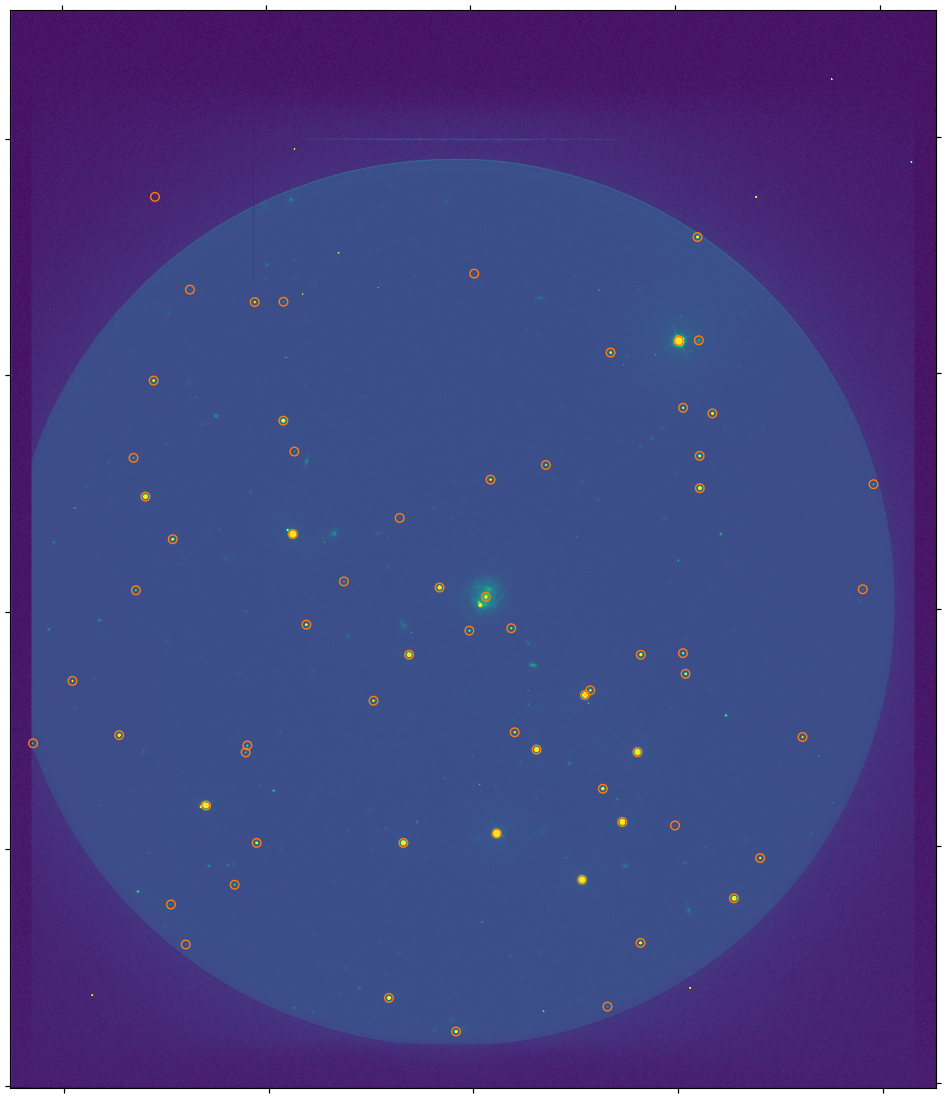

In [27]:
astromFile = '/home/mayank/astronomybro/processing/acam761.proc.fits'

with fits.open(astromFile) as HDUList:
    img = HDUList[0].data
    header = HDUList[0].header

wcs = WCS(header) # the following obtains the transformation matrix from the header

ra = data['field_ra']
dec = data['field_dec']

# changing the coordinates of reference stars from WCS to pixels using tranformation obtained by solving astrometry
coordsx, coordsy = wcs.all_world2pix(ra, dec, 0) 

patch_list = [Circle((x, y), radius=10, fill=False, ec='C1') for x, y in zip(coordsx, coordsy)]

fig = plt.figure(figsize=(14,14))
ax = plt.subplot(projection=wcs) # changes the coordinate system to WCS
mean, median, std = sigma_clipped_stats(img)

plt.imshow(img, vmin=median-3*std, vmax=median+10*std, origin="lower")

for p in patch_list:
    ax.add_patch(p)

plt.show()

You can see that the reference stars align with our image, hence we must be doing something right.

## Resampling

The above image does not have North up and East to the left, the normal convention for displaying astronomical images.  The easiest way to project an image to the standard reference system is to resample it using SWarp, another piece of external code.  This can be done as follows:

In [21]:
input_files = ['processing/acam761.proc.fits', 'processing/acam762.proc.fits', 'processing/acam763.proc.fits']
for i, file in enumerate(input_files, start=1):
    output_file = f'output_file_{i}.fits'
    weight_file = f'weight_file_{i}.fits'
    command = f'SWarp {file} -c stack.swarp -IMAGEOUT_NAME {output_file} -WEIGHTOUT_NAME {weight_file} -RESAMPLE_DIR processing'
    print(f'Running command: {command}')
    !{command}

Running command: SWarp processing/acam761.proc.fits -c stack.swarp -IMAGEOUT_NAME output_file_1.fits -WEIGHTOUT_NAME weight_file_1.fits -RESAMPLE_DIR processing

> WARNING: stack.swarp not found, using internal defaults

> 
----- SWarp 2.41.5 started on 2024-06-15 at 11:31:30 with 6 threads

> Examining input data ...
> Looking for acam761.proc.fits ...
> Creating NEW output image ...
> Creating NEW weight-map ...
> 
------- Output File output_file_1.fits:
    "no ident"  WEIGHTED  no ext. header  2631x2263  32 bits (floats)
    Center: 16:16:02.59 +22:16:00.7   11.1'x9.54'  Scale: 0.2528 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X

> Loading input data ...
> 
-------------- File acam761.proc.fits:
    "AT2018cow 0.0 0.0"  unweighted  no ext. header  2148x2501  64 bits (floats)
    Center: 16:16:02.60 +22:16:00.8   9.05'x10.5'  Scale: 0.2528 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X
> Setting up background maps ...
> Setting up back

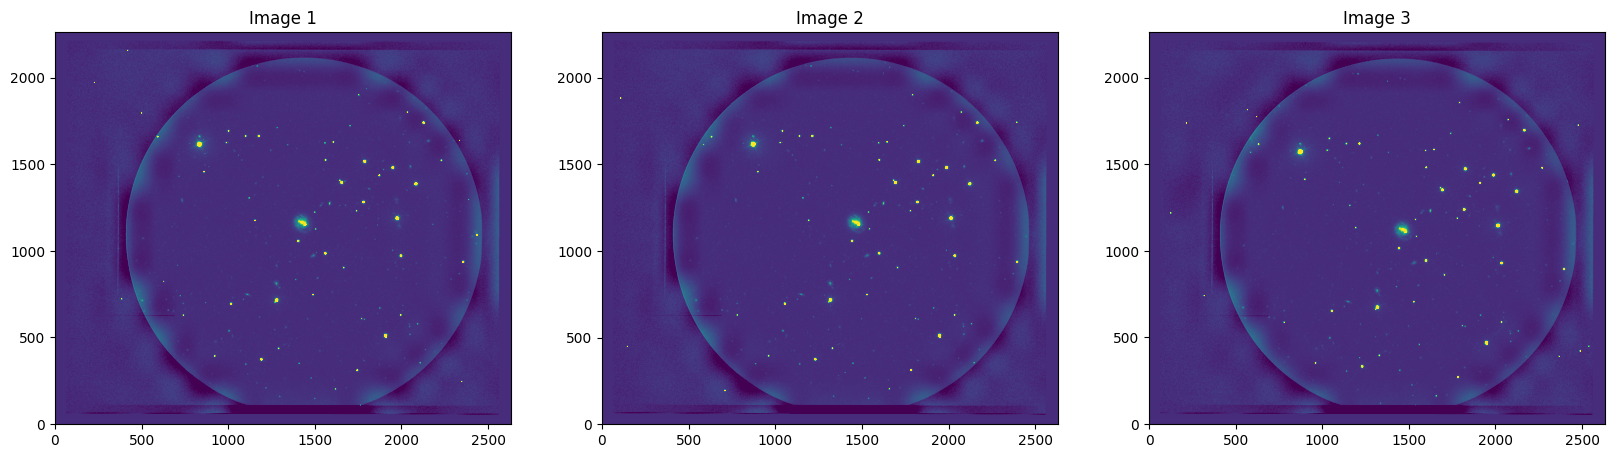

In [32]:
output_files = ['output_file_1.fits', 'output_file_2.fits', 'output_file_3.fits']

fig, axes = plt.subplots(1, 3, figsize=(20, 20), subplot_kw={'projection': None})
for i, file in enumerate(output_files):
    # Open the FITS file
    HDUList = fits.open(file)
    
    # Extract WCS and data
    wcs = WCS(HDUList[0].header)
    resampledData = HDUList[0].data
    
    # Close the FITS file
    HDUList.close()
    
    # Calculate statistics
    mean, median, std = sigma_clipped_stats(resampledData)
    
    # Display the resampled image
    axes[i].imshow(resampledData, vmin=mean-3*std, vmax=mean+20*std, origin='lower')
    axes[i].set_title(f"Image {i+1}")

plt.show()